# Customer Churn Analysis
Churn rate, when applied to a customer base, refers to the proportion of contractual customers or subscribers who leave a supplier during a given time period. It is a possible indicator of customer dissatisfaction, cheaper and/or better offers from the competition, more successful sales and/or marketing by the competition, or reasons having to do with the customer life cycle.

Churn is closely related to the concept of average customer life time. For example, an annual churn rate of 25 percent implies an average customer life of four years. An annual churn rate of 33 percent implies an average customer life of three years. The churn rate can be minimized by creating barriers which discourage customers to change suppliers (contractual binding periods, use of proprietary technology, value-added services, unique business models, etc.), or through retention activities such as loyalty programs. It is possible to overstate the churn rate, as when a consumer drops the service but then restarts it within the same year. Thus, a clear distinction needs to be made between "gross churn", the total number of absolute disconnections, and "net churn", the overall loss of subscribers or members. The difference between the two measures is the number of new subscribers or members that have joined during the same period. Suppliers may find that if they offer a loss-leader "introductory special", it can lead to a higher churn rate and subscriber abuse, as some subscribers will sign on, let the service lapse, then sign on again to take continuous advantage of current specials. https://en.wikipedia.org/wiki/Churn_rate

In [ ]:
Hello team!

In [1]:
%%capture

import numpy as np
import pandas as pd
import h2o
from h2o.automl import H2OAutoML
from __future__ import print_function
import skater

# Suppress unwatned warnings
#import warnings
#warnings.filterwarnings('ignore')
#import logging
#logging.getLogger("requests").setLevel(logging.WARNING)

In [2]:
# Load our favorite visualization library
import os
import plotly
import plotly.plotly as py
import plotly.figure_factory as ff
import plotly.graph_objs as go
import cufflinks as cf
plotly.offline.init_notebook_mode(connected=True)

# Sign into Plotly with masked, encrypted API key

myPlotlyKey = os.environ['SECRET_ENV_BRETTS_PLOTLY_KEY']
py.sign_in(username='bretto777',api_key=myPlotlyKey)


In [3]:
# Load some data
churnDF = pd.read_csv('https://s3-us-west-1.amazonaws.com/dsclouddata/home/jupyter/churn_train.csv', delimiter=',')
churnDF["Churn"] = churnDF["Churn"].replace(to_replace=False, value='Retain')
churnDF["Churn"] = churnDF["Churn"].replace(to_replace=True, value='Churn')
churnDFs = churnDF.sample(frac=0.07) # Sample for speedy viz
churnDF.head(10)

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn
0,ND,84,415,400-7253,no,yes,33,159.1,106,27.05,...,101,12.73,213.4,108,9.60,13.0,18,3.51,1,Retain
1,RI,117,408,370-5042,no,yes,13,207.6,65,35.29,...,77,12.98,232.8,95,10.48,9.7,3,2.62,1,Retain
2,VA,132,510,343-4696,no,no,0,81.1,86,13.79,...,72,20.84,237.0,115,10.67,10.3,2,2.78,0,Retain
3,OK,121,408,364-2495,no,yes,31,237.1,63,40.31,...,117,17.48,196.7,85,8.85,10.1,5,2.73,4,Retain
4,ME,205,510,413-4039,no,yes,24,175.8,139,29.89,...,98,13.18,180.7,64,8.13,7.8,5,2.11,2,Retain
5,MT,116,415,384-5907,no,yes,35,182.8,122,31.08,...,119,18.08,193.8,103,8.72,11.0,2,2.97,1,Retain
6,MN,113,408,417-5146,no,no,0,158.9,137,27.01,...,109,20.64,247.8,97,11.15,6.5,4,1.76,0,Retain
7,MO,74,415,421-2955,no,no,0,172.1,105,29.26,...,99,17.99,182.2,105,8.20,11.6,6,3.13,1,Retain
8,MI,112,510,420-1383,no,no,0,243.4,77,41.38,...,97,15.48,259.2,94,11.66,12.8,2,3.46,1,Retain
9,UT,68,415,403-8916,no,no,0,213.9,112,36.36,...,100,22.14,233.8,97,10.52,8.4,3,2.27,1,Churn


## Scatterplot Matrix

In [4]:
# separate the calls data for plotting

churnDFs = churnDFs[['Account Length','Day Calls','Eve Calls','CustServ Calls','Churn']]

# Create scatter plot matrix of call data
splom = ff.create_scatterplotmatrix(churnDFs, diag='histogram', index='Churn',  
                                  colormap= dict(
                                      Churn = '#9CBEF1',
                                      Retain = '#04367F'
                                      ),
                                  colormap_type='cat',
                                  height=560, width=650,
                                  size=4, marker=dict(symbol='circle'))
py.iplot(splom)

In [6]:
%%capture

#h2o.connect(ip="35.225.239.147")
h2o.init(nthreads=1, max_mem_size="768m")

In [7]:
%%capture

# Split data into training and testing frames

from sklearn import cross_validation
from sklearn.model_selection import train_test_split

training, testing = train_test_split(churnDF, train_size=0.8, stratify=churnDF["Churn"], random_state=9)
train = h2o.H2OFrame(python_obj=training).drop("State")
test = h2o.H2OFrame(python_obj=testing).drop("State")

# Set predictor and response variables
y = "Churn"
x = train.columns
x.remove(y)

# Automatic Machine Learning

The Automatic Machine Learning (AutoML) function automates the supervised machine learning model training process. The current version of AutoML trains and cross-validates a Random Forest, an Extremely-Randomized Forest, a random grid of Gradient Boosting Machines (GBMs), a random grid of Deep Neural Nets, and a Stacked Ensemble of all the models.

In [8]:
%%capture
# Run AutoML until 11 models are built
autoModel = H2OAutoML(max_models = 11)
autoModel.train(x = x, y = y,
          training_frame = train,
          validation_frame = test, 
          leaderboard_frame = test)

## Leaderboard

In [9]:
leaders = autoModel.leaderboard
leaders

model_id,auc,logloss
StackedEnsemble_BestOfFamily_0_AutoML_20171208_200732,0.952947,0.131093
StackedEnsemble_AllModels_0_AutoML_20171208_200732,0.952825,0.130346
GBM_grid_0_AutoML_20171208_200732_model_1,0.951462,0.13149
GBM_grid_0_AutoML_20171208_200732_model_2,0.94841,0.13453
GBM_grid_0_AutoML_20171208_200732_model_3,0.941147,0.136001
GBM_grid_0_AutoML_20171208_200732_model_0,0.940125,0.139511
GBM_grid_0_AutoML_20171208_200732_model_4,0.939662,0.187097
DRF_0_AutoML_20171208_200732,0.93353,0.406308
XRT_0_AutoML_20171208_200732,0.9297,0.257414
GBM_grid_0_AutoML_20171208_200732_model_5,0.920939,0.229441


# Variable Importances
Below we plot variable importances as reported by the best performing algo in the ensemble.

In [50]:
importances = h2o.get_model(leaders[2, 0]).varimp(use_pandas=True)
importances = importances.loc[:,['variable','relative_importance']].groupby('variable').mean()
importances.sort_values(by="relative_importance", ascending=False).iplot(kind='bar', colors='#5AC4F2', theme='white')

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


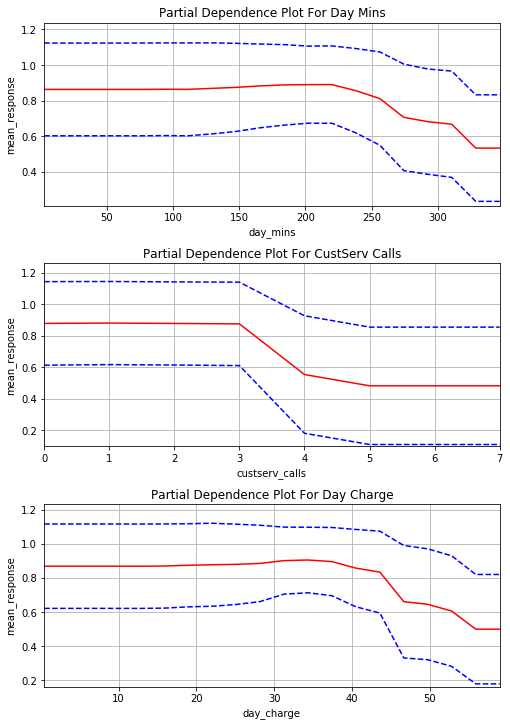

In [55]:
import matplotlib.pyplot as plt
plt.figure()
bestModel = h2o.get_model(leaders[2, 0])
plt = bestModel.partial_plot(data=test, cols=["Day Mins","CustServ Calls","Day Charge"])


# Best Model vs the Base Learners
This plot shows the ROC curves for the Super Model, the Best Base Model, and 9 next best models in the ensemble. 

In [51]:
Model0 = np.array(h2o.get_model(leaders[0,0]).roc(xval=True))
Model1 = np.array(h2o.get_model(leaders[1,0]).roc(xval=True))
Model2 = np.array(h2o.get_model(leaders[2,0]).roc(xval=True))
Model3 = np.array(h2o.get_model(leaders[3,0]).roc(xval=True))
Model4 = np.array(h2o.get_model(leaders[4,0]).roc(xval=True))
Model5 = np.array(h2o.get_model(leaders[5,0]).roc(xval=True))
Model6 = np.array(h2o.get_model(leaders[6,0]).roc(xval=True))
Model7 = np.array(h2o.get_model(leaders[7,0]).roc(xval=True))
Model8 = np.array(h2o.get_model(leaders[8,0]).roc(xval=True))
Model9 = np.array(h2o.get_model(leaders[9,0]).roc(xval=True))

layout = go.Layout(autosize=False, width=725, height=575,  xaxis=dict(title='False Positive Rate', titlefont=dict(family='Arial, sans-serif', size=15, color='grey')), 
                                                           yaxis=dict(title='True Positive Rate', titlefont=dict(family='Arial, sans-serif', size=15, color='grey')))

traceChanceLine = go.Scatter(x = [0,1], y = [0,1], mode = 'lines+markers', name = 'chance', line = dict(color = ('rgb(136, 140, 150)'), width = 4, dash = 'dash'))
Model0Trace = go.Scatter(x = Model0[0], y = Model0[1], mode = 'lines', name = 'Model 0', line = dict(color = ('rgb(26, 58, 126)'), width = 3))
Model1Trace = go.Scatter(x = Model1[0], y = Model1[1], mode = 'lines', name = 'Model 1', line = dict(color = ('rgb(156, 190, 241))'), width = 1))
Model2Trace = go.Scatter(x = Model2[0], y = Model2[1], mode = 'lines', name = 'Model 2', line = dict(color = ('rgb(156, 190, 241)'), width = 1))
Model3Trace = go.Scatter(x = Model3[0], y = Model3[1], mode = 'lines', name = 'Model 3', line = dict(color = ('rgb(156, 190, 241)'), width = 1))
Model4Trace = go.Scatter(x = Model4[0], y = Model4[1], mode = 'lines', name = 'Model 4', line = dict(color = ('rgb(156, 190, 241)'), width = 1))
Model5Trace = go.Scatter(x = Model5[0], y = Model5[1], mode = 'lines', name = 'Model 5', line = dict(color = ('rgb(156, 190, 241)'), width = 1))
Model6Trace = go.Scatter(x = Model6[0], y = Model6[1], mode = 'lines', name = 'Model 6', line = dict(color = ('rgb(156, 190, 241)'), width = 1))
Model7Trace = go.Scatter(x = Model7[0], y = Model7[1], mode = 'lines', name = 'Model 7', line = dict(color = ('rgb(156, 190, 241)'), width = 1))
Model8Trace = go.Scatter(x = Model8[0], y = Model8[1], mode = 'lines', name = 'Model 8', line = dict(color = ('rgb(156, 190, 241)'), width = 1))
Model9Trace = go.Scatter(x = Model9[0], y = Model9[1], mode = 'lines', name = 'Model 9', line = dict(color = ('rgb(156, 190, 241)'), width = 1))

fig = go.Figure(data=[Model0Trace,Model1Trace,Model2Trace,Model3Trace,Model4Trace,Model5Trace,Model6Trace,Model8Trace,Model9Trace,traceChanceLine], layout=layout)

py.iplot(fig)

# Confusion Matrix

In [56]:
cm = h2o.get_model(leaders[1, 0]).confusion_matrix(xval=True)
cm = cm.table.as_data_frame()
cm
confusionMatrix = ff.create_table(cm)
confusionMatrix.layout.height=300
confusionMatrix.layout.width=800
confusionMatrix.layout.font.size=17
py.iplot(confusionMatrix)

# Business Impact Matrix

Weighting Predictions With a Dollar Value
-   Correctly predicting retain: `+$5`
-   Correctly predicting churn: `+$75`
-   Incorrectly predicting retain: `-$150`
-   Incorrectly predicting churn: `-$1.5`

    

In [57]:
CorrectPredictChurn = cm.loc[0,'Churn']
CorrectPredictChurnImpact = 75
cm1 = CorrectPredictChurn*CorrectPredictChurnImpact

IncorrectPredictChurn = cm.loc[1,'Churn']
IncorrectPredictChurnImpact = -5
cm2 = IncorrectPredictChurn*IncorrectPredictChurnImpact

IncorrectPredictRetain = cm.loc[0,'Retain']
IncorrectPredictRetainImpact = -150
cm3 = IncorrectPredictRetain*IncorrectPredictRetainImpact

CorrectPredictRetain = cm.loc[0,'Retain']
CorrectPredictRetainImpact = 5
cm4 = IncorrectPredictRetain*CorrectPredictRetainImpact


data_matrix = [['Business Impact', '($) Predicted Churn', '($) Predicted Retain', '($) Total'],
               ['($) Actual Churn', cm1, cm3, '' ],
               ['($) Actual Retain', cm2, cm4, ''],
               ['($) Total', cm1+cm2, cm3+cm4, cm1+cm2+cm3+cm4]]

impactMatrix = ff.create_table(data_matrix, height_constant=20, hoverinfo='weight')
impactMatrix.layout.height=300
impactMatrix.layout.width=800
impactMatrix.layout.font.size=17
py.iplot(impactMatrix)

In [45]:
print("Total customers evaluated: 2132")

Total customers evaluated: 2132


In [61]:
print("Total value created by the model: $" + str(cm1+cm2+cm3+cm4))

Total value created by the model: $4655.0


In [62]:
print("Total value per customer: $" +str(round(((cm1+cm2+cm3+cm4)/2132),3)))

Total value per customer: $2.183


In [48]:
%%capture
# Save the best model

path = h2o.save_model(model=h2o.get_model(leaders[0, 0]), force=True)
os.rename(h2o.get_model(leaders[0, 0]).model_id, "AutoML-leader")    

In [49]:
%%capture
LoadedEnsemble = h2o.load_model(path="AutoML-leader")
print(LoadedEnsemble)